## HR Attrition Prediction

In [1]:
import shap
import numpy as np
import pandas as pd
shap.initjs()
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_columns', None)


ModuleNotFoundError: No module named 'shap'

In [196]:
# Loading fictional employee attrition dataset 
# (modified from https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset)

df = pd.read_excel('C:\\temp8\\hrtestdata3.xlsx', sheet_name = 'hrtestdata', encoding = "ISO-8859-1")

In [197]:
df.shape

(1470, 31)

In [198]:
NewBusinessTravel = pd.get_dummies(df.NewBusinessTravel)
df = pd.concat([df,NewBusinessTravel],axis='columns')

Department = pd.get_dummies(df.Department)
df = pd.concat([df,Department],axis='columns')

EducationField = pd.get_dummies(df.EducationField)
df = pd.concat([df,EducationField],axis='columns')

Gender = pd.get_dummies(df.Gender)
df = pd.concat([df,Gender],axis='columns')

JobRole = pd.get_dummies(df.JobRole)
df = pd.concat([df,JobRole],axis='columns')

MaritalStatus = pd.get_dummies(df.MaritalStatus)
df = pd.concat([df,MaritalStatus],axis='columns')

Overtime = pd.get_dummies(df.Overtime)
df = pd.concat([df,Overtime],axis='columns')

In [199]:
df.drop(['NewBusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 
         'MaritalStatus', 'Overtime'], axis = 1, inplace=True)


In [200]:
df.drop(['OT - No'], axis = 1, inplace=True)

In [201]:
#Separate data to response variable and feature variables
X = df.drop(['Target_Attrition'], axis = 1)
y = df['Target_Attrition']

In [202]:
#Train and test splitting of data into train and test - stu
train = df[df['group'] == 0]
test = df[df['group'] == 1]

In [203]:
df.describe()

,Age,group,Target_Attrition,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,MonthlySalary,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusTravel - Frequent,BusTravel - None,BusTravel - Rare,HR Dept,Research & Development,Sales,Human Resources,Life Sciences,Marketing,Medical,Other,Technical Degree,Female,Male,Job Role - HR,Job Role - Healthcare Rep,Job Role - Lab Tech,Job Role - Manager,Job Role - Manufactoring Dir,Job Role - Research Director,Job Role - Research Scientist,Job Role - Sales Executive,Job Role - Sales Representative,Divorced,Married,Single,OT - Yes
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,0.530612,0.161224,9.192517,2.912925,1024.865306,2.721769,2.729932,2.063946,2.728571,6502.931293,2.693197,15.209524,3.153741,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129,0.188435,0.102041,0.709524,0.042857,0.653741,0.303401,0.018367,0.412245,0.108163,0.315646,0.055782,0.089796,0.400000,0.600000,0.035374,0.089116,0.176190,0.069388,0.098639,0.054422,0.198639,0.221769,0.056463,0.222449,0.457823,0.319728,0.282993
std,9.135373,0.499232,0.367863,8.106864,1.024165,602.024335,1.093082,0.711561,1.106940,1.102846,4707.956783,2.498009,3.659938,0.360824,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136,0.391193,0.302805,0.454137,0.202604,0.475939,0.459884,0.134321,0.492406,0.310692,0.464931,0.229579,0.285986,0.490065,0.490065,0.184786,0.285008,0.381112,0.254199,0.298279,0.226925,0.399112,0.415578,0.230891,0.416033,0.498387,0.466530,0.450606
min,18.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1009.000000,0.000000,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,0.000000,0.000000,2.000000,2.000000,491.250000,2.000000,2.000000,1.000000,2.000000,2911.000000,1.000000,12.000000,3.000000,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,36.000000,1.000000,0.000000,7.000000,3.000000,1020.500000,3.000000,3.000000,2.000000,3.000000,4919.000000,2.000000,14.000000,3.000000,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,43.000000,1.000000,0.000000,14.000000,4.000000,1555.750000,4.000000,3.000000,3.000000,4.000000,8379.000000,4.000000,18.000000,3.000000,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000,0.0

In [204]:
#Split and train data to train and test 
X_train = train[train['group'] == 0] 
X_test = test[test['group'] == 1] 
y_train = X_train.pop('Target_Attrition').values
y_test = X_test.pop('Target_Attrition').values
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train[:2]
y_train[:2]

(690, 50) (690,) (780, 50) (780,)


array([1, 0], dtype=int64)

In [205]:
y_test = pd.Series(y_test)
print(type(y_test))

y_train = pd.Series(y_train)
print(type(y_train))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


## XG Boost Classifier Model

In [206]:
from xgboost import XGBClassifier

model = XGBClassifier(max_depth=4,        objective="binary:logistic",               subsample = 1,
                      n_estimators=100,      learning_rate = .01,                  random_state=262,
                      reg_alpha=0,             reg_lambda= 1,          eta = 1,             min_child_weight = .5,
                     colsample_bytree = .5)
model.fit(X_train,y_train)
y_predict_proba =  model.predict_proba(X_test)
y_predict =  model.predict(X_test)
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print(accuracy_score(y_test,y_predict))

0.8576923076923076


## Shap Invididual and Summary Plots

In [207]:
 obj = shap.plots.force(
        base_value=explainer.expected_value,
        shap_values=shap_values[index,:],
        features=X.loc[index, :],
        link="logit",
        )#.data

In [208]:
obj

In [209]:
# make sure the SHAP values add up to marginal predictions
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

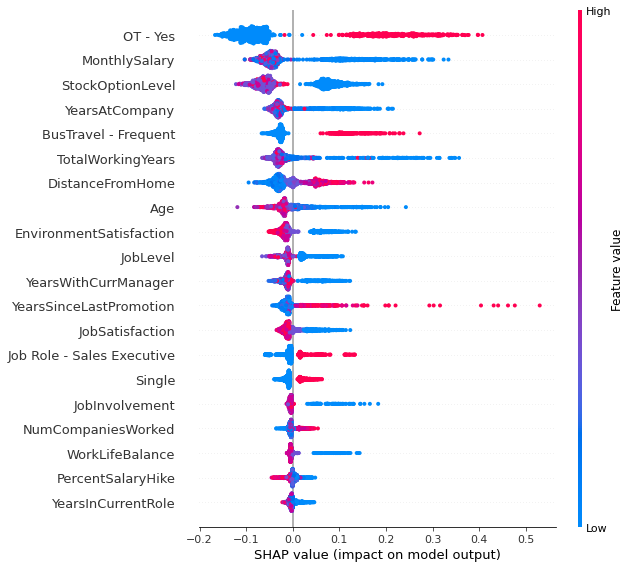

In [210]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X, max_display= 20)

#shap.summary_plot(shap_values, X, max_display=X.shape[1])

## ForcePlot Extraction Function

In [211]:
index = 0

In [212]:
def extract_importance_details(X, y, explainer, shap_values, index, model,  criteria = None):

    """
    Collect the following items per example
        - top +ve and -ve feature contributions to example prediction,
        - model predicted probability of action
        - ground truth result (if available)
    """

    shap_value = shap_values[index]
    expected_value = explainer.expected_value
    
    obj = shap.plots.force(
        base_value=expected_value,
        shap_values=shap_value,
        features=X.loc[index, :],
        link="logit",
        ).data
    
    feature_df = pd.DataFrame(obj['features']).T
    feature_df['Name'] = feature_df.index.map(lambda x: obj['featureNames'][x])
               
    min5 = feature_df.sort_values('effect').head(5)
    min5['status'] = list(map(lambda x: 'rank_{}negative'.format(x+1),range(5)))
    min5 = min5.set_index('status')

    max5 = feature_df.sort_values('effect', ascending=False).head(5)
    max5['status'] = list(map(lambda x: 'rank_{}positive'.format(x+1),range(5)))
    max5 = max5.set_index('status')     
               
    top_features = pd.concat((min5,max5))           
    
    # Flatten to a single row
    v = top_features.unstack().to_frame().sort_index(level=1).T
    v.columns = v.columns.map('_'.join)
               
    # Add additional variables of importance
    v.insert(loc=0, column='predicted_proba',
    value=model.predict_proba(X.loc[[index]])[0][1])
    v.insert(loc=0, column='df_index', value=index) 
    
    return v
               

 

In [213]:
def get_packaged_output(X, y, model, criteria=None):

    """
    Create a package of individual shap reports for searchable feature impacts
    """
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
 
    packaged_output = pd.DataFrame()
    for index, row in X.iterrows():
        package = extract_importance_details(X, y, explainer, shap_values, index, model, criteria)
        packaged_output = pd.concat((packaged_output, package), ignore_index=True)                                   
  
    return packaged_output

In [214]:
print(type(shap_values))

<class 'numpy.ndarray'>


In [215]:
extract_importance_details(X_test, y_test, explainer, shap_values, index, model,  criteria = None)

,df_index,predicted_proba,Name_rank_1negative,effect_rank_1negative,value_rank_1negative,Name_rank_1positive,effect_rank_1positive,value_rank_1positive,Name_rank_2negative,effect_rank_2negative,value_rank_2negative,Name_rank_2positive,effect_rank_2positive,value_rank_2positive,Name_rank_3negative,effect_rank_3negative,value_rank_3negative,Name_rank_3positive,effect_rank_3positive,value_rank_3positive,Name_rank_4negative,effect_rank_4negative,value_rank_4negative,Name_rank_4positive,effect_rank_4positive,value_rank_4positive,Name_rank_5negative,effect_rank_5negative,value_rank_5negative,Name_rank_5positive,effect_rank_5positive,value_rank_5positive
0,0,0.293423,MonthlySalary,-0.0694015,5993,OT - Yes,0.192937,1,DistanceFromHome,-0.0613508,1,StockOptionLevel,0.0819362,0,TotalWorkingYears,-0.0515028,8,WorkLifeBalance,0.0552037,1,JobLevel,-0.0402816,2,Job Role - Sales Executive,0.0534476,1,YearsAtCompany,-0.0388801,6,Single,0.0300858,1


In [216]:
len(shap_values)

1470

In [217]:
X_test = X_test.reset_index(drop=True)

In [218]:
X_test.tail()

,Age,group,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,MonthlySalary,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusTravel - Frequent,BusTravel - None,BusTravel - Rare,HR Dept,Research & Development,Sales,Human Resources,Life Sciences,Marketing,Medical,Other,Technical Degree,Female,Male,Job Role - HR,Job Role - Healthcare Rep,Job Role - Lab Tech,Job Role - Manager,Job Role - Manufactoring Dir,Job Role - Research Director,Job Role - Research Scientist,Job Role - Sales Executive,Job Role - Sales Representative,Divorced,Married,Single,OT - Yes
775,29,1,28,4,2054,4,2,1,1,3785,1,14,3,2,80,0,5,3,1,5,4,0,4,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0
776,31,1,5,3,2057,2,3,2,1,9936,0,19,3,2,80,0,10,2,3,9,4,1,7,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0
777,36,1,23,2,2061,3,4,2,4,2571,4,17,3,3,80,1,17,3,3,5,2,0,3,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0
778,39,1,6,1,2062,4,2,3,1,9991,4,15,3,1,80,1,9,5,3,7,7,1,7,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0
779,34,1,8,3,2068,2,4,2,3,4404,2,12,3,1,80,0,6,3,4,4,3,1,2,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0


In [219]:
report = get_packaged_output(X_test, y_test, model)

In [220]:
report 

,df_index,predicted_proba,Name_rank_1negative,effect_rank_1negative,value_rank_1negative,Name_rank_1positive,effect_rank_1positive,value_rank_1positive,Name_rank_2negative,effect_rank_2negative,value_rank_2negative,Name_rank_2positive,effect_rank_2positive,value_rank_2positive,Name_rank_3negative,effect_rank_3negative,value_rank_3negative,Name_rank_3positive,effect_rank_3positive,value_rank_3positive,Name_rank_4negative,effect_rank_4negative,value_rank_4negative,Name_rank_4positive,effect_rank_4positive,value_rank_4positive,Name_rank_5negative,effect_rank_5negative,value_rank_5negative,Name_rank_5positive,effect_rank_5positive,value_rank_5positive
0,0,0.293423,MonthlySalary,-0.0694015,5993,OT - Yes,0.192937,1,DistanceFromHome,-0.0613508,1,StockOptionLevel,0.0819362,0,TotalWorkingYears,-0.0515028,8,WorkLifeBalance,0.0552037,1,JobLevel,-0.0402816,2,Job Role - Sales Executive,0.0534476,1,YearsAtCompany,-0.0388801,6,Single,0.0300858,1
1,1,0.238438,OT - Yes,-0.0648034,0,BusTravel - Frequent,0.100489,1,StockOptionLevel,-0.0527253,1,Education,0.0137637,1,MonthlySalary,-0.0473495,5130,BusTravel - Rare,0.0013755,0,YearsAtCompany,-0.0366727,10,Medical,0.000884576,0,TotalWorkingYears,-0.0228042,10,BusTravel - None,0.000692211,0
2,2,0.262013,OT - Yes,-0.130883,0,YearsAtCompany,0.0837304,2,StockOptionLevel,-0.0639909,1,EnvironmentSatisfaction,0.0658635,1,DistanceFromHome,-0.0379478,2,NumCompaniesWorked,0.0398248,9,BusTravel - Frequent,-0.0305078,0,Age,0.0212522,27,MonthlySalary,-0.0302206,3468,JobLevel,0.0170612,1
3,3,0.393482,OT - Yes,-0.108434,0,TotalWorkingYears,0.289324,1,StockOptionLevel,-0.0641793,1,DistanceFromHome,0.162503,24,EnvironmentSatisfaction,-0.0430941,4,MonthlySalary,0.130844,2693,BusTravel - Frequent,-0.0409761,0,YearsAtCompany,0.121581,1,Single,-0.0312094,0,YearsWithCurrManager,0.100868,0
4,4,0.264428,OT - Yes,-0.0776311,0,BusTravel - Frequent,0.0959709,1,MonthlySalary,-0.0436908,9526,StockOptionLevel,0.0643339,0,YearsAtCompany,-0.0360299,9,DistanceFromHome,0.0534592,23,TotalWorkingYears,-0.0330219,10,Single,0.0215893,1,YearsSinceLastPromotion,-0.0263891,1,RelationshipSatisfaction,0.00342053,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,775,0.297144,OT - Yes,-0.0975273,0,WorkLifeBalance,0.107423,1,MonthlySalary,-0.0403227,3785,JobSatisfaction,0.0793406,1,YearsAtCompany,-0.0322386,5,StockOptionLevel,0.0596748,0,EnvironmentSatisfaction,-0.0279326,4,DistanceFromHome,0.0352542,28,BusTravel - Frequent,-0.0247396,0,EmployeeNumber,0.0246949,2054
776,776,0.261893,OT - Yes,-0.0719556,0,JobSatisfaction,0.0699696,1,MonthlySalary,-0.0418134,9936,EmployeeNumber,0.0535449,2057,TotalWorkingYears,-0.0354569,10,StockOptionLevel,0.0477619,0,YearsAtCompany,-0.026764,9,Single,0.0150976,1,BusTravel - Frequent,-0.0262945,0,Age,0.00962288,31
777,777,0.277162,OT - Yes,-0.0788595,0,BusTravel - Frequent,0.120765,1,YearsAtCompany,-0.0454868,5,MonthlySalary,0.0922603,2571,YearsWithCurrManager,-0.0421411,3,EmployeeNumber,0.071096,2061,StockOptionLevel,-0.0285597,1,DistanceFromHome,0.0305055,23,Age,-0.0265308,36,Job Role - Lab Tech,0.00458902,1
778,778,0.252642,OT - Yes,-0.0590035,0,EmployeeNumber,0.12079,2062,MonthlySalary,-0.036807,9991,JobSatisfaction,0.0308182,1,TotalWorkingYears,-0.0292121,9,Education,0.00894688,1,StockOptionLevel,-0.0277026,1,RelationshipSatisfaction,0.00141388,1,BusTravel - Frequent,-0.023166,0,BusTravel - None,0.000779585,0


# Saving Model

In [221]:
report2 = report

In [222]:
#Create datastructure to hold negative factors

neg_Name = pd.melt(report2, id_vars=['df_index'], 
                       value_vars=['Name_rank_1negative','Name_rank_2negative',
                                  'Name_rank_3negative', 'Name_rank_4negative',
                                  'Name_rank_5negative'])

neg_effect = pd.melt(report2, id_vars=['df_index'], 
                       value_vars=['effect_rank_1negative','effect_rank_2negative',
                                  'effect_rank_3negative', 'effect_rank_4negative',
                                  'effect_rank_5negative'])

neg_value = pd.melt(report2, id_vars=['df_index'], 
                       value_vars=['value_rank_1negative','value_rank_2negative',
                                  'value_rank_3negative', 'value_rank_4negative',
                                  'value_rank_5negative'])

# print(neg_Name)
# print(neg_effect)
# print(neg_value)

neg_concat = pd.concat([neg_Name, neg_effect, neg_value], axis=1)
neg_concat.head()

neg_concat.to_csv('C:\\temp8\\neg_concat2.csv')

In [223]:
#Create datastructure to hold postive factors

pos_Name = pd.melt(report2, id_vars=['df_index'], 
                       value_vars=['Name_rank_1positive','Name_rank_2positive',
                                  'Name_rank_3positive', 'Name_rank_4positive',
                                  'Name_rank_5positive'])

pos_effect = pd.melt(report2, id_vars=['df_index'], 
                       value_vars=['effect_rank_1positive','effect_rank_2positive',
                                  'effect_rank_3positive', 'effect_rank_4positive',
                                  'effect_rank_5positive'])

pos_value = pd.melt(report2, id_vars=['df_index'], 
                       value_vars=['value_rank_1positive','value_rank_2positive',
                                  'value_rank_3positive', 'value_rank_4positive',
                                  'value_rank_5positive'])

# print(neg_Name)
# print(neg_effect)
# print(neg_value)

pos_concat = pd.concat([pos_Name, pos_effect, pos_value], axis=1)
pos_concat

# print(neg_Name_concat)
pos_concat.to_csv('C:\\temp8\\pos_concat2.csv')